# Step-53

This is a replica of [step-53](https://www.dealii.org/current/doxygen/deal.II/step_53.html) C++ tutorial program. However, here we will use the deal.II Python interface to implement the functionality of the original tutorial. 

Not all of the material is replicated since some parts of the original C++ tutorial are only relevant when using C++. Therefore, it is recommended that you first go through the original C++ tutorial to see all the details covered there.

*This notebook is contributed by Alexander Grayver, 2020*

## Python initialization

Provided the deal.II library was compiled with the python wrappers, we can import the module **PyDealII**. Note that it is only a shell and importing it will only allow you to call
```python 
help(PyDealII)
``` 
**PyDealII** is composed of two libraries: 
 - **PyDealII.Debug** which uses the debug version of **deal.II**
 - **PyDealII.Release** which uses the release version of **deal.II**
 
Let us import the release version of the library and give it the shortname **dealii**

In [1]:
import PyDealII.Release as dealii

In addition, we will import a few widely used python packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import re
import math

%matplotlib inline

## Introduction

Partial differential equations for realistic problems are often posed on
domains with complicated geometries. To provide just a few examples, consider
these cases:
- Among the two arguably most important industrial applications for the finite
  element method, aerodynamics and more generally fluid dynamics is
  one. Computer simulations today are used in the design of every airplane,
  car, train and ship. The domain in which the partial differential equation
  is posed is, in these cases, the air surrounding the plane with its wings,
  flaps and engines; the air surrounding the car with its wheel, wheel wells,
  mirrors and, in the case of race cars, all sorts of aerodynamic equipment;
  the air surrounding the train with its wheels and gaps between cars. In the
  case of ships, the domain is the water surrounding the ship with its rudders
  and propellers.
- The other of the two big applications of the finite element method is
  structural engineering in which the domains are bridges, airplane nacelles
  and wings, and other solid bodies of often complicated shapes.
- Finite element modeling is also often used to describe the generation and
  propagation of earthquake waves. In these cases, one needs to accurately
  represent the geometry of faults in the Earth crust. Since faults intersect,
  dip at angles, and are often not completely straight, domains are frequently
  very complex.
One could cite many more examples of complicated geometries in which one wants
to pose and solve a partial differential equation. What this shows is that the
"real" world is much more complicated than what we have shown in almost all of
the tutorial programs preceding this one.

This program is therefore devoted to showing how one deals with complex
geometries using a concrete application. In particular, what it shows is how
we make a mesh fit the domain we want to solve on. On the other hand, what the
program does not show is how to create a coarse for a domain. The process to
arrive at a coarse mesh is called "mesh generation" and there are a number of
high-quality programs that do this much better than we could ever
implement. However, deal.II does have the ability to read in meshes in many
formats generated by mesh generators and then make them fit a given shape,
either by deforming a mesh or refining it a number of times until it fits. The
deal.II Frequently Asked Questions page referenced from http://www.dealii.org/
provides resources to mesh generators.


### Where geometry and meshes intersect

Let us assume that you have a complex domain and that you already have a
coarse mesh that somehow represents the general features of the domain. Then
there are two situations in which it is necessary to describe to a deal.II
program the details of your geometry:

- Mesh refinement: Whenever a cell is refined, it is necessary to introduce
  new vertices in the [Triangulation](https://www.dealii.org/current/doxygen/deal.II/classTriangulation.html). 
  In the simplest case, one assumes that
  the objects that make up the [Triangulation](https://www.dealii.org/current/doxygen/deal.II/classTriangulation.html) are straight line segments, a
  bi-linear surface or a tri-linear volume. The next vertex is then simply put
  into the middle of the old ones. However, for curved boundaries or if we
  want to solve a PDE on a curved, lower-dimensional manifold embedded in a
  higher-dimensional space, this is insufficient since it will not respect the
  actual geometry. We will therefore have to tell [Triangulation](https://www.dealii.org/current/doxygen/deal.II/classTriangulation.html) where to put
  new points.

- Integration: When using higher order finite element methods, it is often
  necessary to compute integrals using curved approximations of the boundary,
  i.e., describe each edge or face of cells as curves, instead of straight
  line segments or bilinear patches. The same is, of course, true when
  integrating boundary terms (e.g., inhomogeneous Neumann boundary
  conditions). For the purpose of integration, the various [Mapping](https://www.dealii.org/current/doxygen/deal.II/classMapping.html) classes
  then provide the transformation from the reference cell to the actual cell.

In both cases, we need a way to provide information about the geometry of the
domain at the level of an individual cell, its faces and edges. This is where
the Manifold class comes into play. Manifold is an abstract base class that
only defines an interface by which the [Triangulation](https://www.dealii.org/current/doxygen/deal.II/classTriangulation.html) and [Mapping](https://www.dealii.org/current/doxygen/deal.II/classMapping.html) classes can
query geometric information about the domain. Conceptually, [Manifold](https://www.dealii.org/current/doxygen/deal.II/classManifold.html) sees the
world in a way not dissimilar to how the mathematical subdiscipline geometry
sees it: a domain is essentially just a collection of points that is somehow
equipped with the notion of a distance between points so that we can obtain a
point "in the middle" of some other points.

deal.II provides a number of classes that implement the interface provided by
[Manifold](https://www.dealii.org/current/doxygen/deal.II/classManifold.html) for a variety of common geometries. On the other hand, in this
program we will consider only a very common and much simpler case, namely the
situation where (a part of) the domain we want to solve on can be described by
transforming a much simpler domain (we will call this the "reference domain").
In the language of mathematics, this means
that the (part of the) domain is a <a
href="http://en.wikipedia.org/wiki/Chart_%28topology%29">chart</a>. Charts are
described by a smooth function that maps from the simpler domain to the chart
(the "push-forward" function) and its inverse (the "pull-back" function). If
the domain as a whole is not a chart (e.g., the surface of a sphere), then it
can often be described as a collection of charts (e.g., the northern
hemisphere and the southern hemisphere are each charts) and the domain can then
be describe by an <a
href="http://en.wikipedia.org/wiki/Atlas_%28topology%29">atlas</a>.

If a domain can be decomposed into an atlas, all we need to do is provide the
pull-back and push-forward functions for each of the charts. In deal.II, this
means providing a class derived from [ChartManifold](https://www.dealii.org/current/doxygen/deal.II/classChartManifold.html), and this is precisely what
we will do in this program.

### The example case

To illustrate how one describes geometries using charts in deal.II, we will consider a case that originates in an application of the [ASPECT](https://aspect.geodynamics.org/) mantle convection code, using a data set provided by D. Sarah Stamps. In the concrete application, we were interested in describing flow in the Earth mantle under the [East African Rift](http://en.wikipedia.org/wiki/East_African_rift), a zone where two continental plates drift apart. Not to beat around the bush, the geometry we want to describe looks like this:
![Image](https://www.dealii.org/images/steps/developer/step-53.topo.png)

In particular, though you cannot see this here, the top surface is not just colored by the elevation but is, in fact, deformed to follow the correct topography. While the actual application is not relevant here, the geometry is. The domain we are interested in is a part of the Earth that ranges from the surface to a depth of 500km, from 26 to 35 degrees East of the Greenwich meridian, and from 5 degrees North of the equator to 10 degrees South.

This description of the geometry suggests to start with a box
$\hat U=[26,35]\times[-10,5]\times[-500000,0]$ (measured in degrees,
degrees, and meters) and to provide a map $\varphi$ so
that $\varphi^{-1}(\hat U)=\Omega$ where $\Omega$ is the domain we
seek. $(\Omega,\varphi)$ is then a chart, $\varphi$ the pull-back operator, and
$\varphi^{-1}$ the push-forward operator. If we need a point $q$ that is the
"average" of other points $q_i\in\Omega$, the [ChartManifold](https://www.dealii.org/current/doxygen/deal.II/classChartManifold.html) class then first
applies the pull-back to obtain $\hat q_i=\varphi(q_i)$, averages these to a
point $\hat p$ and then computes $p=\varphi^{-1}(\hat p)$.

Our goal here is therefore to implement a class that describes $\varphi$ and
$\varphi^{-1}$. If Earth was a sphere, then this would not be difficult: if we
denote by $(\hat \phi,\hat \theta,\hat d)$ the points of $\hat U$ (i.e.,
longitude counted eastward, latitude counted northward, and elevation relative
to zero depth), then $$\mathbf x = \varphi^{-1}(\hat \phi,\hat \theta,\hat d)
  = (R+\hat d) (\cos\hat \phi\cos\hat \theta, \sin\hat \phi\cos\hat \theta, \sin\hat \theta)^T$$ provides coordinates in a Cartesian coordinate system, where $R$ is the radius
of the sphere. However, the Earth is not a sphere:

1. It is flattened at the poles and larger at the equator: the semi-major axis is approximately 22km longer than the semi-minor axis. We will account for this using the [WGS84](http://en.wikipedia.org/wiki/WGS84) reference standard for the Earth shape. The formula used in WGS 84 to obtain a position in Cartesian coordinates from longitude, latitude, and elevation is $$\mathbf x = \varphi_\text{WGS84}^{-1}(\phi,\theta,d)
  = \left(
    \begin{array}{c}
     (\bar R(\theta)+d) \cos\phi\cos\theta, \\
     (\bar R(\theta)+d) \sin\phi\cos\theta, \\
     ((1-e^2)\bar R(\theta)+d) \sin\theta
    \end{array}
    \right),$$ where $\bar R(\theta)=\frac{R}{\sqrt{1-(e \sin\theta)^2}}$, and radius and ellipticity are given by $R=6378137\text{m}, e=0.081819190842622$. In this formula, we assume that the arguments to sines and cosines are evaluated in degree, not radians (though we will have to change this assumption in the code).

2. It has topography in the form of mountains and valleys. We will account for this using real topography data (see below for a description of where this data comes from). Using this data set, we can look up elevations on a latitude-longitude mesh laid over the surface of the Earth. Starting with the box $\hat U=[26,35]\times[-10,5]\times[-500000,0]$, we will therefore first stretch it in vertical direction before handing it off to the WGS 84 function: if $h(\hat\phi,\hat\theta)$ is the height at longitude $\hat\phi$ and latitude $\hat\theta$, then we define $$(\phi,\theta,d) = \varphi_\text{topo}^{-1}(\hat\phi,\hat\theta,\hat d)
  = \left(
      \hat\phi,
      \hat\theta,
      \hat d + \frac{\hat d+500000}{500000}h(\hat\phi,\hat\theta)
    \right).$$ Using this function, the top surface of the box $\hat U$ is displaced to the correct topography, the bottom surface remains where it was, and points in between are linearly interpolated.

### Implementation

There are a number of issues we need to address in the program. At the largest scale,
we need to write a class that implements the interface of [FunctionManifold](https://www.dealii.org/current/doxygen/deal.II/classFunctionManifold.html) by using the corresponding Python wrapper. This involves
a function <code>push_forward()</code> that takes a point
in the reference domain $\hat U$ and transform it into real space using the function
$\varphi^{-1}$ outlined above, and its inverse function <code>pull_back()</code>
implementing $\varphi$. 

The transformations we need have two parts: the WGS 84 transformations and the topography
transformation. Consequently, we will implement functions
<code>push_forward_wgs84()</code> and
<code>push_forward_topo()</code> that implement these two pieces, and
corresponding pull back functions.

The WGS 84 transformation functions are not particularly interesting (even though the
formulas they implement are impressive). The more interesting part is the topography
transformation. Recall that for this, we needed to evaluate the elevation function
$h(\hat\phi,\hat\theta)$. There is of course no formula for this: Earth is what it is,
the best one can do is look up the altitude from some table. This is, in fact what we
will do.

The data we use was originally created by the  <a
href="http://en.wikipedia.org/wiki/Shuttle_Radar_Topography_Mission">Shuttle
Radar Topography Mission</a>, was downloaded from the US Geologic Survey
(USGS) and processed by D. Sarah Stamps who also wrote the initial version of
the WGS 84 transformation functions. The topography data so processed is
stored in a file <code>topography.txt.gz</code> that, when unpacked
looks like this:

6.983333 25.000000 700<br>
6.983333 25.016667 692<br>
6.983333 25.033333 701<br>
6.983333 25.050000 695<br>
6.983333 25.066667 710<br>
6.983333 25.083333 702<br>
...<br>
-11.983333 35.950000 707<br>
-11.983333 35.966667 687<br>
-11.983333 35.983333 659<br>

The data is formatted as <code>latitude longitude elevation</code> where the first two
columns are provided in degrees North of the equator and degrees East of the Greenwich
meridian. The final column is given in meters above the WGS 84 zero elevation.

In the transformation functions, we need to evaluate $h(\hat\phi,\hat\theta)$ for a given
longitude $\hat\phi$ and latitude $\hat\theta$. In general, this data point will not be
available and we will have to interpolate between adjacent data points. Fortunately, 
widely available scipy library has the functionality for this. 

Having discussed the general outline of how we want to implement things, let us go
to the program and show how it is done in practice.

## The commented program

### Describing topography

First, we read in our topography data from the file:

In [3]:
topo_data = np.loadtxt('topography.txt.gz')
print(topo_data)

[[  6.983333  25.       700.      ]
 [  6.983333  25.05     695.      ]
 [  6.983333  25.1      697.      ]
 ...
 [-11.966667  35.85     722.      ]
 [-11.966667  35.9      738.      ]
 [-11.966667  35.95     693.      ]]


Now, create a 2-D interpolation object that would allow us to retrieve a topography value at an arbitrary location within the area. Since we have data on a regular grid with the known size, it is most efficient to use gridded 2-D interpolation:

In [4]:
from scipy.interpolate import RegularGridInterpolator

lon = np.linspace(start = np.min(topo_data[:,1]), stop = np.max(topo_data[:,1]), num = 220)
lat = np.linspace(start = np.min(topo_data[:,0]), stop = np.max(topo_data[:,0]), num = 380)
altitude = np.reshape(topo_data[:,2], (380, 220))

topo_function = RegularGridInterpolator((lat, lon), altitude)

Let us also plot the data to make sure it looks right:

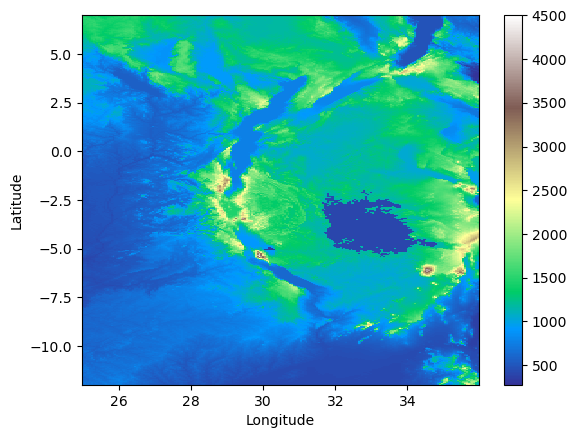

In [5]:
plt.pcolormesh(lon, lat, altitude, cmap='terrain')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.colorbar()

### Describing the geometry

This section describe transformation functions that we will need to construct our manifold.

The following two functions then define the forward and inverse
transformations that correspond to the WGS 84 reference shape of
Earth. The forward transform follows the formula shown in the
introduction. The inverse transform is significantly more complicated
and is, at the very least, not intuitive. It also suffers from the
fact that it returns an angle that at the end of the function we
need to clip back into the interval $[0,2\pi]$ if it should have
escaped from there.

In [6]:
R           = 6378137
ellipticity = 8.1819190842622e-2
r2d = 180. / math.pi
d2r = math.pi / 180.

def push_forward_wgs84(phi_theta_d):
    phi   = phi_theta_d[0]
    theta = phi_theta_d[1]
    d     = phi_theta_d[2]

    R_bar = R / math.sqrt(1. - (ellipticity**2. *
                                math.sin(theta) * math.sin(theta)))

    return [(R_bar + d) * math.cos(phi) * math.cos(theta),
            (R_bar + d) * math.sin(phi) * math.cos(theta),
            ((1. - ellipticity**2.) * R_bar + d) * math.sin(theta)]

def pull_back_wgs84(x):
    b   = math.sqrt(R**2 * (1 - ellipticity**2))
    ep  = math.sqrt((R**2 - b**2) / b**2)
    p   = math.sqrt(x[0]**2. + x[1]**2.)
    th  = math.atan2(R * x[2], b * p)
    phi = math.atan2(x[1], x[0])
    theta = math.atan2(x[2] + ep**2 * b * math.pow(math.sin(th), 3.),
                 (p -
                  (ellipticity**2 * R * math.pow(math.cos(th), 3))))
    R_bar = R / (math.sqrt(1 - ellipticity**2 * math.sin(theta) *
                           math.sin(theta)))
    R_plus_d = p / math.cos(theta)

    phi_theta_d = [0, 0, 0]
    if phi < 0:
        phi_theta_d[0] = phi + 2 * math.pi
    elif phi > 2 * math.pi:
        phi_theta_d[0] = phi - 2 * math.pi
    else:
        phi_theta_d[0] = phi
    phi_theta_d[1] = theta
    phi_theta_d[2] = R_plus_d - R_bar
    
    return phi_theta_d

Next, the topography transformations follow exactly the description in the introduction. The only thing to note here is that we invoke the interpolant for the input topography data that we constructed above:

In [7]:
def push_forward_topo(phi_theta_d_hat):
    d_hat = phi_theta_d_hat[2]
    h = topo_function((phi_theta_d_hat[1]*r2d, phi_theta_d_hat[0]*r2d))
    d = d_hat + (d_hat + 500000.) / 500000. * h
    
    return [phi_theta_d_hat[0], phi_theta_d_hat[1], d]

def pull_back_topo(phi_theta_d):
    d     = phi_theta_d[2]
    h     = topo_function((phi_theta_d[1]*r2d, phi_theta_d[0]*r2d))
    d_hat = 500000. * (d - h) / (500000. + h)
    
    return [phi_theta_d[0], phi_theta_d[1], d_hat]

Finally, both of the pull back and push forward functions are just concatenations of the respective functions of the WGS 84 and topography mappings:

In [8]:
def pull_back(space_point):
    return pull_back_topo(pull_back_wgs84(space_point))

def push_forward(chart_point):
    return push_forward_wgs84(push_forward_topo(chart_point))

Now we are ready to construct a FunctionManifold object with the defined transformations:

In [9]:
geometry = dealii.Manifold(dim = 3, spacedim = 3)
geometry.create_function(push_forward, pull_back)

### Creating the mesh

Having so described the properties of the geometry, not it is
time to deal with the mesh used to discretize it. To this end,
we create objects for the geometry and triangulation, and then
proceed to create a $1\times 2\times 1$ rectangular mesh that
corresponds to the reference domain
$\hat U=[26,35]\times[-10,5]\times[-500000,0]$. We choose
this number of subdivisions because it leads to cells that
are roughly like cubes instead of stretched in one direction or
another.

Of course, we are not actually interested in meshing the
reference domain. We are interested in meshing the real domain.
Consequently, we will use the GridTools::transform() function
that simply moves every point of a triangulation according to
a given transformation. The transformation function it wants is
a function that takes as its single argument a point in the reference
domain and returns the corresponding location in the domain that we
want to map to. This is, of course, exactly the push forward
function of the geometry we use. 

In [10]:
repetitions = [1, 2, 1]
p1 = dealii.Point([26 * d2r, -10 * d2r, -500000])
p2 = dealii.Point([35 * d2r, 5 * d2r, 0.])

triangulation = dealii.Triangulation('3D')
triangulation.generate_subdivided_hyper_rectangle(repetitions,\
                                                  p1, p2, colorize = True)

triangulation.transform(push_forward)

manifold_id = 0

triangulation.set_manifold(number = manifold_id, manifold = geometry)
for cell in triangulation.active_cells():
    cell.set_all_manifold_ids(manifold_id)        

  The last step is to refine the mesh beyond its initial $1\times 2\times
  1$ coarse mesh. We could just refine globally a number of times, but
  since for the purpose of this tutorial program we're really only
  interested in what is happening close to the surface, we just refine 6
  times all of the cells that have a face at a boundary with indicator 5.
  Looking this up in the documentation of the
  GridGenerator::subdivided_hyper_rectangle() function we have used above
  reveals that boundary indicator 5 corresponds to the top surface of the
  domain (and this is what the last <code>True</code> argument in the call
  to *generate_subdivided_hyper_rectangle()* above meant: to "color"
  the boundaries by assigning each boundary a unique boundary indicator).

In [11]:
for n in range(6):
    for cell in triangulation.active_cells():
        for face in cell.faces():
            if face.at_boundary() and face.boundary_id == 5:
                cell.refine_flag ='isotropic'
                
    triangulation.execute_coarsening_and_refinement()

Let us now print some statistics about our mesh:

In [12]:
fmt_str = '# of cells = %d\nsmallest cell = %0.1f m\nlargest cell = %0.1f m'
print(fmt_str % (triangulation.n_active_cells(),\
                 triangulation.minimal_cell_diameter(),\
                 triangulation.maximal_cell_diameter()))

# of cells = 19112
smallest cell = 21579.0 m
largest cell = 660950.0 m


We can finally save the mesh:

In [13]:
triangulation.write('mesh.vtu', 'vtu')

This gives us the following mesh (here coloured by the element volume):

![Image](https://www.dealii.org/images/steps/developer/step-53.mesh.png)

For more details about visualization and discussion of results with underlying issues the reader is referred to the section [Results](https://www.dealii.org/current/doxygen/deal.II/step_53.html) of the original tutorial program.